In [ ]:
#!pip install pydicom pillow

In [ ]:
#!apt-get install -y libgdcm-tools

In [ ]:
#!pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

In [2]:
!pip install dicomsdl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.9 MB/s eta 0:00:00ta 0:00:01


In [3]:
import numpy as np
import pydicom
import os
from tqdm import tqdm  # Importar la versión de tqdm para notebooks
from pathlib import Path
import dicomsdl
import multiprocessing as mp
from PIL import Image
import shutil  # Para mover archivos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import pandas as pd

In [ ]:

# RESIZE_TO = (512, 512)

# # Crear directorio de trabajo
# !rm -rf train_images_processed_cv2_dicomsdl_{RESIZE_TO[0]}
# !mkdir train_images_processed_cv2_dicomsdl_{RESIZE_TO[0]}

# def dicom_file_to_ary(path):
#     dcm_file = dicomsdl.open(str(path))
#     data = dcm_file.pixelData()

#     # Convertir explícitamente a un array de NumPy y verificar el tipo
#     data = np.array(data, dtype=np.float32)

#     if data.size == 0 or not isinstance(data, np.ndarray):
#         raise ValueError(f"La imagen en {path} no contiene datos válidos para procesar o no es un array de NumPy.")

#     # Verificar si el array es continuo en memoria
#     if not data.flags['C_CONTIGUOUS']:
#         data = np.ascontiguousarray(data)

#     # Asegurarse de que data sea 2D
#     if len(data.shape) != 2:
#         raise ValueError(f"La imagen en {path} no es 2D y no se puede redimensionar con PIL. Forma actual: {data.shape}")

#     # Normalizar y convertir a uint8 antes de redimensionar
#     data = (data - data.min()) / (data.max() - data.min())
#     data = (data * 255).astype(np.uint8)

#     # Usar PIL para redimensionar
#     try:
#         image = Image.fromarray(data)
#         image = image.resize(RESIZE_TO, Image.LANCZOS)
#         data_resized = np.array(image, dtype=np.uint8)  # Convertir explícitamente a uint8
#         data_resized = np.ascontiguousarray(data_resized)

#     except Exception as e:
#         print(f"Error al redimensionar la imagen en {path} con PIL: {e}")
#         raise

#     return data_resized

# directories = list(Path('/kaggle/input/rsna-breast-cancer-detection/train_images').iterdir())

# def process_directory(directory_path):
#     parent_directory = str(directory_path).split('/')[-1]
#     output_dir = f'train_images_processed_cv2_dicomsdl_{RESIZE_TO[0]}/{parent_directory}'
#     os.makedirs(output_dir, exist_ok=True)
    
#     image_paths = list(directory_path.iterdir())
    
#     with tqdm(total=len(image_paths), desc=f'Procesando carpeta {parent_directory}', leave=False) as pbar:
#         for image_path in image_paths:
#             processed_ary = dicom_file_to_ary(image_path)
            
#             # Guardar la imagen usando PIL
#             image_to_save = Image.fromarray(processed_ary)
#             image_to_save.save(f'{output_dir}/{image_path.stem}.png')
            
#             pbar.update(1)

# # Usar tqdm para monitorear el progreso general del procesamiento de directorios
# with mp.Pool(mp.cpu_count()) as pool:
#     for _ in tqdm(pool.imap_unordered(process_directory, directories), total=len(directories), desc="Progreso general de carpetas"):
#         pass

Completamos el df con la ubicación de cada imagen png

In [4]:
train_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

test_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')


base_path='/kaggle/input/imagenes-png/kaggle/working'

# saving image path into train dataframe
train_df['img_path']= f'{base_path}/train_images_processed_cv2_dicomsdl_512'\
                    + '/' + train_df.patient_id.astype(str)\
                    + '/' + train_df.image_id.astype(str)\
                    + '.png'



display(train_df.head(3))

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/imagenes-png/kaggle/working/trai...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/imagenes-png/kaggle/working/trai...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/imagenes-png/kaggle/working/trai...


In [ ]:
#!zip -r /kaggle/working/processed_images.zip /kaggle/working/train_images_processed_cv2_dicomsdl_512


In [ ]:
train_df.info()

In [ ]:
train_df.describe()

Validación de variables con nulos

In [ ]:
train_df.BIRADS.value_counts()

In [5]:
# Filtrar pacientes con BIRADS NaN y verificar si tienen cáncer
patients_with_nan_BIRADS = train_df[train_df['BIRADS'].isna()]
patients_with_cancer_nan_BIRADS = patients_with_nan_BIRADS[patients_with_nan_BIRADS['cancer'] == 1]

# Cantidad de pancientes con cancer y clasificación BIRADS nan
print(len(patients_with_cancer_nan_BIRADS))

494


In [6]:
# Reemplazar los valores NaN en la columna BIRADS con 0 solo si la paciente tiene cáncer
train_df.loc[(train_df['BIRADS'].isna()) & (train_df['cancer'] == 1), 'BIRADS'] = 0

In [7]:
#Se cambian valores nulos en variable BIRADS por 2, suponiendo que todos estos casos no obtuvieron una clasificación de BIRADS por parte del radiologo que hizo 
#la evaluación y que la mama no presentó ningun tipo de hallazgo (0 si la mama requirió seguimiento, 
# 1 si la mama se calificó como negativa para cáncer y 
# 2 si la mama se calificó como normal)
train_df.BIRADS.fillna(2,inplace=True)

/tmp/ipykernel_226/1059150911.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df.BIRADS.fillna(2,inplace=True)


In [8]:
#Verificamos variable despues de la imputación
train_df.BIRADS.value_counts()

BIRADS
2.0    30191
1.0    15772
0.0     8743
Name: count, dtype: int64

In [9]:
#Validamos densidad
train_df.density.value_counts()

density
B    12651
C    12175
A     3105
D     1539
Name: count, dtype: int64

In [10]:
# Contar el número de pacientes con cáncer por cada clasificación de densidad
count_by_density = train_df[train_df['cancer'] == 1]['density'].value_counts()

# Mostrar el resultado
print(count_by_density)

density
B    309
C    277
A     53
D     25
Name: count, dtype: int64


In [10]:
# Calcular la proporción de cada categoría de densidad
density_proportions = train_df['density'].value_counts(normalize=True)

# Reemplazar los valores faltantes de la columna 'density' con base en la proporción
missing_density_count = train_df['density'].isna().sum()

# Generar valores aleatorios basados en la proporción calculada
replacements = np.random.choice(
    density_proportions.index,
    size=missing_density_count,
    p=density_proportions.values
)

# Asignar los valores aleatorios a las posiciones donde 'density' es NaN
train_df.loc[train_df['density'].isna(), 'density'] = replacements

print(train_df['density'].value_counts())

density
B    23468
C    22676
A     5738
D     2824
Name: count, dtype: int64


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   54706 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  54706 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
 14  img_path              

cancer
0    53548
1     1158
Name: count, dtype: int64


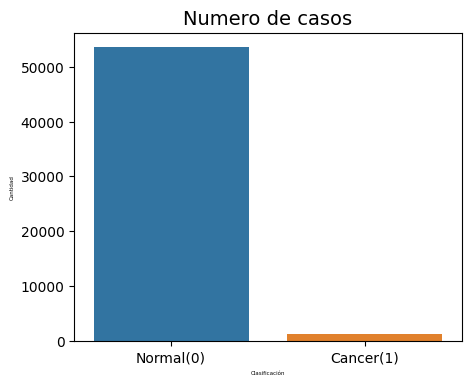

In [12]:
cases_count = train_df['cancer'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,4))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Numero de casos', fontsize=14)
plt.xlabel('Clasificación', fontsize=4)
plt.ylabel('Cantidad', fontsize=4)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Cancer(1)'])
plt.show()

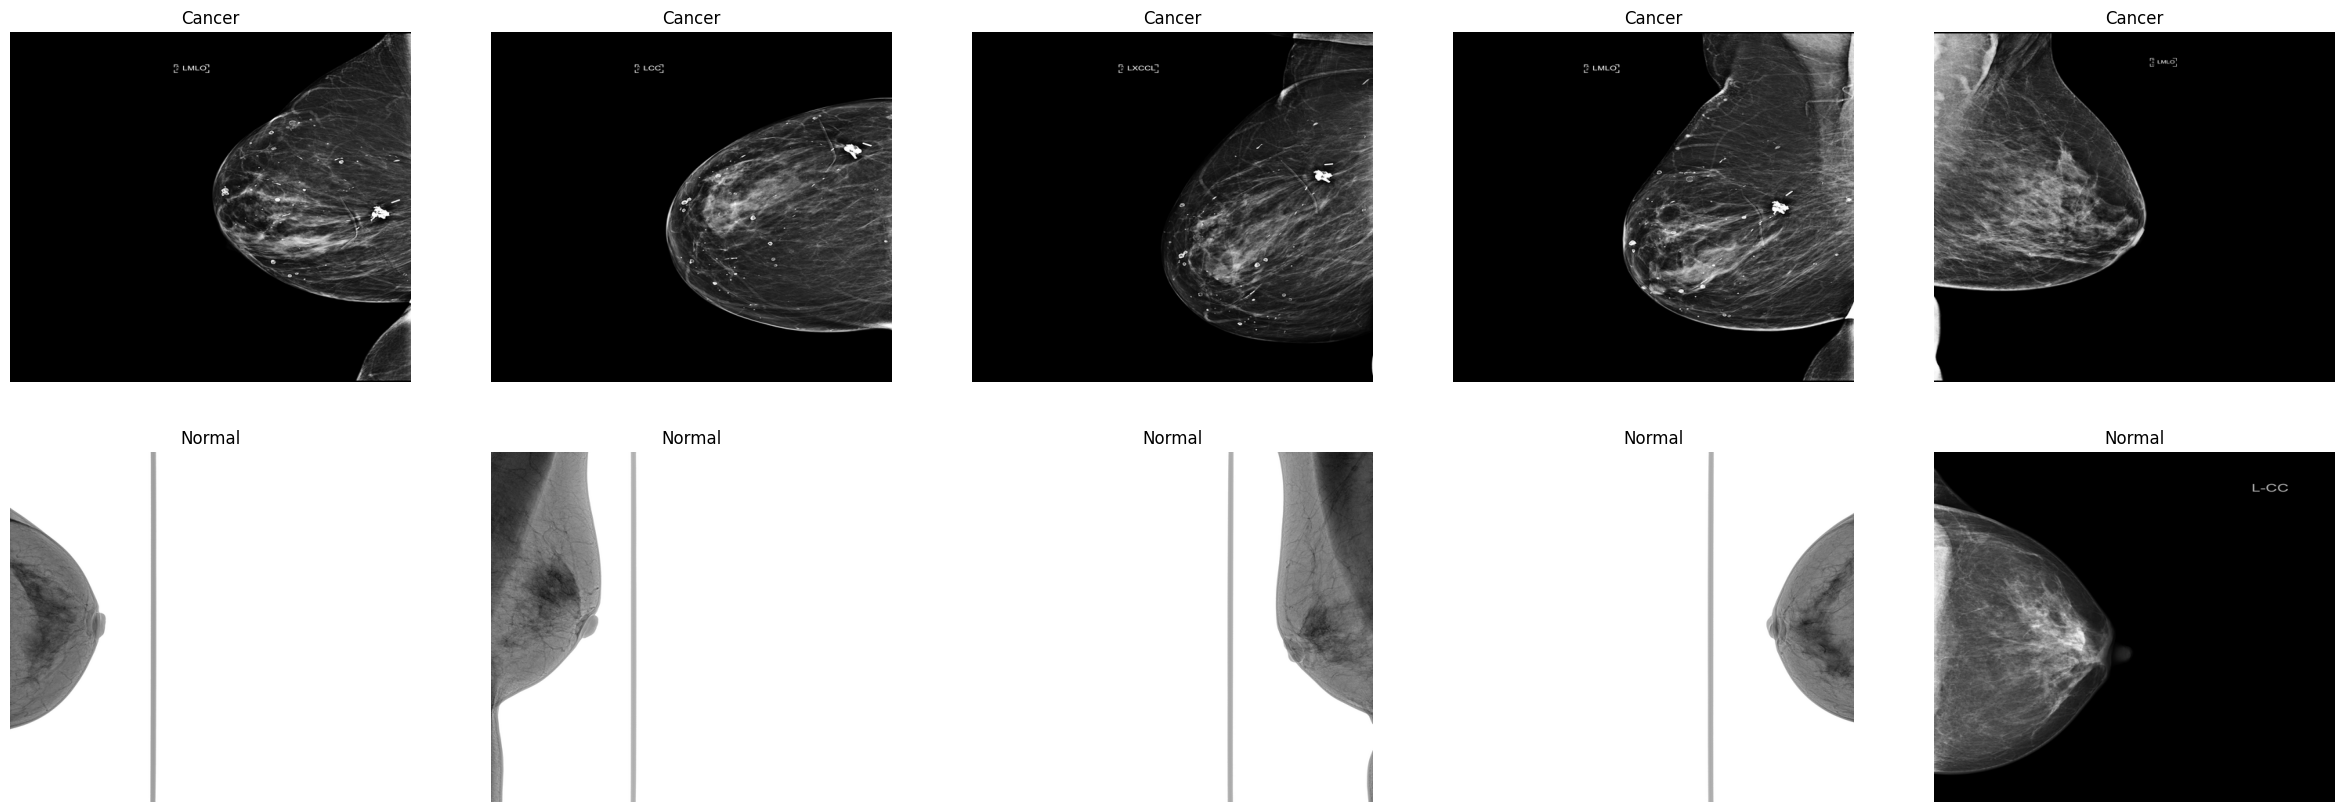

In [13]:
#Visualizar imagenes clasificadas con cancer y no cancer
Cancer_samples = (train_df[train_df['cancer']==1]['img_path'].iloc[0:5]).tolist()
Normal_samples = (train_df[train_df['cancer']==0]['img_path'].iloc[0:5]).tolist()

samples = Cancer_samples + Normal_samples

f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = tf.keras.preprocessing.image.load_img(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Cancer")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [ ]:
# Separar los datos entre pacientes con cáncer y sin cáncer
cancer_df = train_df[train_df['cancer'] == 1]
no_cancer_df = train_df[train_df['cancer'] == 0]

# Crear una figura con dos gráficos (uno para cáncer, otro para no cáncer)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Gráfico para pacientes con cáncer ---
sns.histplot(cancer_df['age'], kde=True, bins=20, color='lightcoral', edgecolor='black', ax=axes[0])

# Calcular estadísticos para pacientes con cáncer
mean_age_cancer = cancer_df['age'].mean()
median_age_cancer = cancer_df['age'].median()
min_age_cancer = cancer_df['age'].min()
max_age_cancer = cancer_df['age'].max()

# Añadir líneas de estadísticos
axes[0].axvline(mean_age_cancer, color='red', linestyle='--', label=f'Media: {mean_age_cancer:.2f}')
axes[0].axvline(median_age_cancer, color='green', linestyle='--', label=f'Mediana: {median_age_cancer:.2f}')
axes[0].axvline(min_age_cancer, color='blue', linestyle='--', label=f'Mínimo: {min_age_cancer:.2f}')
axes[0].axvline(max_age_cancer, color='purple', linestyle='--', label=f'Máximo: {max_age_cancer:.2f}')
# Añadir anotaciones
axes[0].text(mean_age_cancer + 1, axes[0].get_ylim()[1] * 0.8, f'{mean_age_cancer:.2f}', color='red')
axes[0].text(median_age_cancer + 1, axes[0].get_ylim()[1] * 0.7, f'{median_age_cancer:.2f}', color='green')
axes[0].text(min_age_cancer + 1, axes[0].get_ylim()[1] * 0.6, f'{min_age_cancer:.2f}', color='blue')
axes[0].text(max_age_cancer + 1, axes[0].get_ylim()[1] * 0.5, f'{max_age_cancer:.2f}', color='purple')

# Título y etiquetas para pacientes con cáncer
axes[0].set_title('Distribución de la Edad en Pacientes con Cáncer', fontsize=16)
axes[0].set_xlabel('Edad', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].legend()

# --- Gráfico para pacientes sin cáncer ---
sns.histplot(no_cancer_df['age'], kde=True, bins=20, color='skyblue', edgecolor='black', ax=axes[1])

# Calcular estadísticos para pacientes sin cáncer
mean_age_no_cancer = no_cancer_df['age'].mean()
median_age_no_cancer = no_cancer_df['age'].median()
min_age_no_cancer = no_cancer_df['age'].min()
max_age_no_cancer = no_cancer_df['age'].max()
# Añadir líneas de estadísticos
axes[1].axvline(mean_age_no_cancer, color='red', linestyle='--', label=f'Media: {mean_age_no_cancer:.2f}')
axes[1].axvline(median_age_no_cancer, color='green', linestyle='--', label=f'Mediana: {median_age_no_cancer:.2f}')
axes[1].axvline(min_age_no_cancer, color='blue', linestyle='--', label=f'Mínimo: {min_age_no_cancer:.2f}')
axes[1].axvline(max_age_no_cancer, color='purple', linestyle='--', label=f'Máximo: {max_age_no_cancer:.2f}')

# Añadir anotaciones
axes[1].text(mean_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.8, f'{mean_age_no_cancer:.2f}', color='red')
axes[1].text(median_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.7, f'{median_age_no_cancer:.2f}', color='green')
axes[1].text(min_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.6, f'{min_age_no_cancer:.2f}', color='blue')
axes[1].text(max_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.5, f'{max_age_no_cancer:.2f}', color='purple')

# Título y etiquetas para pacientes sin cáncer
axes[1].set_title('Distribución de la Edad en Pacientes sin Cáncer', fontsize=16)
axes[1].set_xlabel('Edad', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].legend()
# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [ ]:
# Seleccionar solo las columnas numéricas del DataFrame
numeric_df = train_df.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
corr_matrix = numeric_df.corr()

# Crear el gráfico de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

In [ ]:
# Filtrar los pacientes con cáncer y sin cáncer
cancer_patients = train_df[train_df['cancer'] == 1]
no_cancer_patients = train_df[train_df['cancer'] == 0]

# Configurar estilo visual
sns.set(style="whitegrid")

# Boxplot para comparar las distribuciones de edad
plt.figure(figsize=(10, 6))
sns.boxplot(x='cancer', y='age', data=train_df, palette=['blue', 'red'])
plt.title('Comparación de Edad: Pacientes con y sin Cáncer')
plt.xlabel('Cáncer (0=No, 1=Sí)')
plt.ylabel('Edad')
plt.show()

In [ ]:
# Histograma para visualizar la distribución de la densidad
plt.figure(figsize=(14, 7))

# Densidad en pacientes con cáncer
plt.subplot(1, 2, 1)
sns.histplot(cancer_patients['density'], kde=True, bins=20, color='red', label='Cáncer')
plt.title('Distribución de Densidad Mamaria - Pacientes con Cáncer')
plt.xlabel('Densidad')
plt.ylabel('Frecuencia')
plt.legend()

# Densidad en pacientes sin cáncer
plt.subplot(1, 2, 2)
sns.histplot(no_cancer_patients['density'], kde=True, bins=20, color='blue', label='Sin Cáncer')
plt.title('Distribución de Densidad Mamaria - Pacientes sin Cáncer')
plt.xlabel('Densidad')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Configurar estilo visual
sns.set(style="whitegrid")

# Gráfico de barras para tipo de vista en pacientes con cáncer
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(data=cancer_patients, x='view', palette='Reds')
plt.title('Distribución de Tipos de Vista - Pacientes con Cáncer')
plt.xlabel('Vista (CC o MLO)')
plt.ylabel('Frecuencia')

# Gráfico de barras para tipo de vista en pacientes sin cáncer
plt.subplot(1, 2, 2)
sns.countplot(data=no_cancer_patients, x='view', palette='Blues')
plt.title('Distribución de Tipos de Vista - Pacientes sin Cáncer')
plt.xlabel('Vista (CC o MLO)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [ ]:
# Filtrar casos difíciles y no difíciles
difficult_cases = train_df[train_df['difficult_negative_case'] == True]
non_difficult_cases = train_df[train_df['difficult_negative_case'] == False]

# Configurar estilo visual
sns.set(style="whitegrid")

# Comparar la edad en casos difíciles y no difíciles
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.histplot(difficult_cases['age'], kde=True, bins=20, color='red', label='Difícil')
plt.title('Distribución de Edad - Casos Difíciles')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.histplot(non_difficult_cases['age'], kde=True, bins=20, color='blue', label='No Difícil')
plt.title('Distribución de Edad - Casos No Difíciles')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Comparar el tipo de vista en casos difíciles y no difíciles
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(data=difficult_cases, x='view', palette='Reds')
plt.title('Distribución de Tipos de Vista - Casos Difíciles')
plt.xlabel('Vista (CC o MLO)')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.countplot(data=non_difficult_cases, x='view', palette='Blues')
plt.title('Distribución de Tipos de Vista - Casos No Difíciles')
plt.xlabel('Vista (CC o MLO)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Modelo

In [8]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [9]:
minority_class_size = train_df['cancer'].value_counts().min()

# Definir la proporción de muestras de la clase mayoritaria (ejemplo: 2 veces la clase minoritaria)
majority_class_multiplier = 10
majority_class_size = minority_class_size * majority_class_multiplier

# Obtener todas las muestras de la clase minoritaria
minority_samples = train_df[train_df['cancer'] == 1]

# Obtener una muestra aleatoria de la clase mayoritaria
majority_samples = train_df[train_df['cancer'] == 0].sample(majority_class_size, random_state=42)

# Combinar las muestras de ambas clases
balanced_df = pd.concat([minority_samples, majority_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar el balance de clases
print(balanced_df['cancer'].value_counts())

cancer
0    11580
1     1158
Name: count, dtype: int64


In [10]:
# # Filtrar solo las imágenes con la vista 'MLO'
# train_df_mlo = train_df[train_df['view'] == 'MLO']
balanced_df['label'] = balanced_df['cancer']  # Usar 'cancer' como la etiqueta

# Dividir en conjuntos de entrenamiento y validación
train_df_mlo, val_df_mlo = train_test_split(balanced_df, test_size=0.3, random_state=42,stratify=balanced_df['label'] )

In [11]:
train_df_mlo['img_path'].iloc[0]

'/kaggle/input/imagenes-png/kaggle/working/train_images_processed_cv2_dicomsdl_512/59628/713557806.png'

In [12]:
# Convertir la columna 'label' a tipo string
train_df_mlo['label'] = train_df_mlo['label'].astype(str)
val_df_mlo['label'] = val_df_mlo['label'].astype(str)


In [ ]:
#!pip install tensorflow_addons

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)  # Handle NaN
    return K.mean(f1)

def focal_loss(y_true, y_pred, gamma=2., alpha=0.25):
    y_true = tf.cast(y_true, dtype=tf.float32)
    alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred) + tf.keras.backend.epsilon()
    focal_loss_value = -alpha_t * tf.pow(1 - p_t, gamma) * tf.math.log(p_t)
    return tf.reduce_mean(focal_loss_value)

# Cargar el modelo base de EfficientNetB0 preentrenado
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
base_model.trainable = False  # Congelar las capas preentrenadas

# Crear el modelo completo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo con la métrica personalizada
model.compile(optimizer=Adam(learning_rate=1e-5), loss=focal_loss, metrics=[f1_score])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint

# Callback para reducir la tasa de aprendizaje si la métrica de validación no mejora
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

# Callback de TensorBoard para seguimiento visual
tensorboard1 = TensorBoard(
    log_dir='logs',
    histogram_freq=1,
    write_graph=True,
    write_images=True
)

# Callback para guardar el mejor modelo basado en F1-score
checkpoint1 = ModelCheckpoint(
    'efficientnet_best_model.keras',
    monitor='val_f1_score',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear ImageDataGenerator para el entrenamiento y la validación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generadores de datos
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df_mlo,  # DataFrame filtrado para la vista 'MLO'
    x_col='img_path',
    y_col='label',
    target_size=(512, 512),  # Tamaño de las imágenes
    batch_size=32,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df_mlo,
    x_col='img_path',
    y_col='label',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary'
)


In [ ]:
class_weights = {0: 1, 1: 10}
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,  # Ajusta el número de épocas según tus necesidades
    class_weight=class_weights,
    callbacks=[reduce_lr, tensorboard1, checkpoint1]
)

In [ ]:
# Descongelar las capas superiores para ajuste fino
base_model.trainable = True

# Congelar todas las capas excepto las últimas capas de EfficientNet
for layer in base_model.layers[:-20]:  # Ajusta el número según cuántas capas quieras descongelar
    layer.trainable = False

# Compilar de nuevo con una tasa de aprendizaje baja para el ajuste fino
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=focal_loss,
              metrics=[f1_score])

# Reentrenar para el ajuste fino
history_fine_tune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,  # Más épocas para el ajuste fino
    callbacks=[reduce_lr, tensorboard1, checkpoint1]
)


In [ ]:
# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(val_gen)

print(f"Pérdida en validación: {val_loss:.4f}")
print(f"Precisión en validación: {val_accuracy:.4f}")


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Generar predicciones
y_pred = model.predict(val_gen)
y_pred_classes = np.round(y_pred).astype(int)  # Redondear a 0 o 1

# Obtener las etiquetas reales
y_true = val_gen.classes

# Imprimir el informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_true, y_pred_classes))

# Imprimir la matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(y_true, y_pred_classes))


Red neuronal no preentrenada

In [ ]:
# Definición de la red neuronal
import tensorflow as tf
from tensorflow.keras import layers, models

def simple_cnn(input_shape=(512, 512, 3)):
    model = models.Sequential()

    # Primera capa convolucional
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Segunda capa convolucional
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Tercera capa convolucional
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Cuarta capa convolucional
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Aplanar y conectar a capas densas
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Regularización
    model.add(layers.Dense(1, activation='sigmoid'))  # Salida binaria

    return model

# Crear el modelo
model = simple_cnn(input_shape=(512, 512, 3))


In [ ]:
#Compilar el modelo
from tensorflow.keras.optimizers import Adam

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4),  # Ajustar tasa de aprendizaje
              loss='binary_crossentropy',
              metrics=[f1_score, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [ ]:
#Configurar los generadores de datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Generador para aumentación de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizar
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generadores
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df_mlo,  # DataFrame con datos de entrenamiento
    x_col='img_path',
    y_col='label',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df_mlo,  # DataFrame con datos de validación
    x_col='img_path',
    y_col='label',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary'
)


In [ ]:
#Entrenamieto del modelo
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

checkpoint = ModelCheckpoint(
    'simple_cnn_best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[reduce_lr, checkpoint]
)

In [ ]:
#Evaluar el modelo
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_gen)

print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")


In [14]:
!pip install --upgrade ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 70.4 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0

In [15]:
from transformers import ViTConfig, ViTForImageClassification, ViTImageProcessor
from PIL import Image
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuración del modelo ViT para 512x512
config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
config.image_size = 512  # Ajustar tamaño de entrada
config.num_labels = 2  # Clasificación binaria
model = ViTForImageClassification(config).to(device)

In [1]:
# Procesador de imágenes
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Función para preprocesar imágenes
def preprocess_image(img_path):
    image = Image.open(img_path).convert("RGB")
    image = image.resize((224, 224))  # Reducir tamaño a 224x224
    inputs = processor(images=image, return_tensors="pt")
    return inputs

# Preparar datos
def prepare_data(dataframe, processor):
    inputs = []
    labels = []
    for idx, row in dataframe.iterrows():
        input_img = preprocess_image(row['img_path'])
        inputs.append(input_img['pixel_values'][0])
        labels.append(row['cancer'])
    return torch.stack(inputs), torch.tensor(labels)

NameError: name 'ViTImageProcessor' is not defined

In [18]:
# Dividir datos en entrenamiento y validación
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=42, stratify=balanced_df['label'])

In [ ]:
# Preprocesar datos
train_inputs, train_labels = prepare_data(train_df, processor)
val_inputs, val_labels = prepare_data(val_df, processor)

In [ ]:
# Crear DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_inputs, train_labels)
val_dataset = TensorDataset(val_inputs, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Configurar optimizador y pérdida
from transformers import AdamW
from torch.nn import CrossEntropyLoss

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = CrossEntropyLoss()

# Entrenar el modelo
epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)['logits']
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch + 1}, Training Loss: {train_loss / len(train_loader)}")

    # Validación
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)['logits']
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f"Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {accuracy:.4f}")
